### 1. Creating a `pfl` Dataset Object
A `pfl.data.Dataset` object is the basic representation for a single user's dataset. Alternatively, this can also be used for building a central dataset for evaluation purpose (to be used with `pfl.callback.CentralEvaluationCallback`).   

In [1]:
import sklearn.datasets
from pfl.data.dataset import Dataset

# Create synthetic user data
user_id = 'pfl-user-0'
user_features, user_labels = sklearn.datasets.make_classification(n_samples=10, n_features=4)

# Create a pfl Dataset object
user_dataset = Dataset(raw_data=[user_features, user_labels], user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"Batch from `Dataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")

Batch from `Dataset`: 
x shape=(5, 4), x=[[-2.42578649  0.36091291  1.31437232 -1.71293635]
 [ 0.76625724 -1.1077005   0.97480493  1.44248524]
 [-1.14293831 -0.32780859  1.31568849 -0.35545332]
 [-0.16826458  0.74147808 -0.91099515 -0.76871939]
 [ 0.40668616 -0.87734018  0.9222357   1.02814293]]
y shape=(5,), y=[1 1 1 0 1]


#### 1.1 Creating a PyTorch `pfl` Dataset Object
The above example showed how to create the `pfl` dataset in numpy format. `pfl`  supports data that are processed in PyTorch or TensorFlow tensors. We will focus on PyTorch for the purpose of this tutorial. The TensorFlow dataset implementation can be found at [tensorflow.py](https://github.com/apple/pfl-research/blob/main/pfl/data/tensorflow.py).

In [2]:
import multiprocessing
import os
os.environ['PFL_PYTORCH_DEVICE'] = 'cpu'

import torch

# Set multiprocessing start method to "spawn" instead of forkserver (which is the default)
# That is because forkserver does not work on Windows, but spawn does.
def init_multiprocessing():
    try:
        multiprocessing.set_start_method("spawn", force=True)  # Forces "spawn"
    except RuntimeError:
        pass  # Ignore if it's already set

init_multiprocessing()

from pfl.internal.ops.selector import set_framework_module
from pfl.internal.ops import pytorch_ops, numpy_ops
from pfl.data.pytorch import PyTorchTensorDataset, PyTorchDataDataset

# Tell pfl to use pytorch as the backend ML framework
set_framework_module(pytorch_ops, old_module=numpy_ops)

In [3]:
# Option 1: Create a PyTorch pfl Dataset object based on PyTorch tensors
user_features, user_labels = torch.as_tensor(user_features), torch.as_tensor(user_labels)
user_dataset = PyTorchTensorDataset(tensors=[user_features, user_labels], user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"Batch from `PyTorchTensorDataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")

Batch from `PyTorchTensorDataset`: 
x shape=torch.Size([5, 4]), x=tensor([[-2.4258,  0.3609,  1.3144, -1.7129],
        [ 0.7663, -1.1077,  0.9748,  1.4425],
        [-1.1429, -0.3278,  1.3157, -0.3555],
        [-0.1683,  0.7415, -0.9110, -0.7687],
        [ 0.4067, -0.8773,  0.9222,  1.0281]], dtype=torch.float64)
y shape=torch.Size([5]), y=tensor([1, 1, 1, 0, 1], dtype=torch.int32)


In [4]:
# Option 2: Create a PyTorch pfl Dataset object based on torch.utils.data.Dataset
pytorch_data = torch.utils.data.TensorDataset(user_features, user_labels)
user_dataset = PyTorchDataDataset(raw_data=pytorch_data, user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"\nBatch from `PyTorchDataDataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")


Batch from `PyTorchDataDataset`: 
x shape=torch.Size([5, 4]), x=tensor([[-2.4258,  0.3609,  1.3144, -1.7129],
        [ 0.7663, -1.1077,  0.9748,  1.4425],
        [-1.1429, -0.3278,  1.3157, -0.3555],
        [-0.1683,  0.7415, -0.9110, -0.7687],
        [ 0.4067, -0.8773,  0.9222,  1.0281]], dtype=torch.float64)
y shape=torch.Size([5]), y=tensor([1, 1, 1, 0, 1], dtype=torch.int32)


### 2. Creating Federated Dataset with Real User Partition
Previous section showed how to create a single user dataset.  This section covers how to create a federated dataset which is a joint of multiple users' dataset. If the original dataset already have an attribute for user identifier, such as [StackOverflow](https://www.kaggle.com/datasets/stackoverflow/stackoverflow), [LEAF](https://leaf.cmu.edu) ans [FLAIR](https://github.com/apple/ml-flair), we can use the existing user parition in the dataset for more accurate simulation of non-IID characteristics in the real federated learning setting. 

In [5]:
from pfl.data import get_user_sampler, FederatedDataset

# Create a dataset partitioned by user
user_id_to_data = {}
n_users = 20
for i in range(n_users):
    user_id_to_data[i] = sklearn.datasets.make_classification(n_samples=i+1, n_features=4)
user_ids = list(user_id_to_data.keys())

# Create user sampler to sample user uniformly at random
user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)
federated_dataset = FederatedDataset.from_slices(data=user_id_to_data, user_sampler=user_sampler)

# Iterate federated dataset to get artificial user dataset
print("FederatedDataset with real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user with user_id={user_dataset.user_id} has size of {len(user_dataset)}.")

FederatedDataset with real user partition: 
	Real user with user_id=18 has size of 19.
	Real user with user_id=5 has size of 6.
	Real user with user_id=1 has size of 2.
	Real user with user_id=3 has size of 4.
	Real user with user_id=5 has size of 6.


#### 2.1 Creating a `PyTorchFederatedDataset` Object
In certain scenario, it might be beneficial to use `PyTorchFederatedDataset` for speeding up data loading. 

In [6]:
from pfl.data.pytorch import PyTorchFederatedDataset

class PyTorchDataset(torch.utils.data.Dataset):
    def __init__(self, user_id_to_data):
        self._user_id_to_data = user_id_to_data

    def __getitem__(self, i):
        return [torch.as_tensor(x) for x in self._user_id_to_data[i]]

    def __len__(self):
        return len(self._user_id_to_data)


pytorch_dataset = PyTorchDataset(user_id_to_data)
federated_dataset = PyTorchFederatedDataset(dataset=pytorch_dataset, user_sampler=user_sampler)
# Iterate federated dataset to get artificial user dataset
print("PyTorchFederatedDataset with real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user {i} has size of {len(user_dataset)}.")

PyTorchFederatedDataset with real user partition: 
	Real user 0 has size of 6.
	Real user 1 has size of 15.
	Real user 2 has size of 4.
	Real user 3 has size of 16.
	Real user 4 has size of 1.


#### 2.2 Creating a `FederatedDataset` with `torch.utils.data.Dataset`
If a user dataset is too large to fit into memory, `pfl` also supports `torch.utils.data.Dataset` for creating federated dataset.


In [7]:
def make_dataset_fn(user_id):
    # Create a `torch.utils.data.Dataset` for a single user
    user_data = [torch.as_tensor(data) for data in user_id_to_data[user_id]]
    pytorch_data = torch.utils.data.TensorDataset(*user_data)
    return PyTorchDataDataset(raw_data=pytorch_data, user_id=user_id)

federated_dataset = FederatedDataset(make_dataset_fn=make_dataset_fn, user_sampler=user_sampler)
print("FederatedDataset with torch.utils.data.Dataset and real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user {i} has size of {len(user_dataset)}.")

FederatedDataset with torch.utils.data.Dataset and real user partition: 
	Real user 0 has size of 19.
	Real user 1 has size of 19.
	Real user 2 has size of 9.
	Real user 3 has size of 15.
	Real user 4 has size of 6.


### 3. Creating IID Artificial Federated Dataset
The previous section assumes that a dataset has user IDs, which is often not the case for many existing ML datasets (e.g. CIFAR10). For those datasets, `pfl` supports converting them to Artificial Federated Dataset, meaning that there is no user ID associated with the dataset and the user partition will be artificial, which is useful for experimenting existing ML datasets. This section covers how to create an Artificial Federated Dataset assuming the data distribution between users is IID. 

In [8]:
import numpy as np
from pfl.data import ArtificialFederatedDataset, get_data_sampler


n_samples = 1000
features, labels = sklearn.datasets.make_classification(n_samples=n_samples, n_features=8, n_informative=4, n_classes=5)
# Create data sampler to sample each artificial user dataset as a random subset of the original dataset
data_sampler = get_data_sampler(sample_type="random", max_bound=n_samples)

# Option 1: Create an artificial federated dataset where each user dataset has constant size of 10
sample_dataset_len = lambda: 10
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("User dataset size is a constant: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")

User dataset size is a constant: 
	Artificial user 0 has size of 10
	Artificial user 1 has size of 10
	Artificial user 2 has size of 10
	Artificial user 3 has size of 10
	Artificial user 4 has size of 10


In [9]:
# Option 2: Create an artificial federated dataset where each user dataset size follows Poisson distribution
sample_dataset_len = lambda: max(1, np.random.poisson(10))
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("\nUser dataset size follows a Poisson distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")


User dataset size follows a Poisson distribution: 
	Artificial user 0 has size of 7
	Artificial user 1 has size of 15
	Artificial user 2 has size of 15
	Artificial user 3 has size of 13
	Artificial user 4 has size of 10


### 4. Creating non-IID Artificial Federated Dataset
As mentioned before, in the real federated setting, the federated data has many non-IID characteristics in its distribution. This section shows how to artificially simulate the case for a classification dataset where the user label distribution is non-IID and follows a Dirichlet distribution (a common assumption in federated learning research). 

#### 4.1 Sampling non-IID user dataset dynamically with `ArtificialFederatedDataset`
The first option is to change the `data_sampler` in a way so that the user label distribution follows a Dirichlet distribution. The user dataset is sampled on the fly and there is no fixed user partition like as in [Section 3.2](#3.2-Partitioning-the-dataset-into-fixed-artificial-users-with-FederatedDataset) below.

In [10]:
# Create data sampler to sample each artificial user has label distribution follows a Dirichlet distribution.
dirichlet_alpha = [0.1] * 5
data_sampler = get_data_sampler(sample_type="dirichlet", labels=labels, alpha=dirichlet_alpha)

# Create an artificial federated dataset with a Dirichlet data sampler
sample_dataset_len = lambda: 20
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("ArtificialFederatedDataset with Dirichlet label distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)} with unique labels={np.unique(user_dataset.raw_data[1])}")

ArtificialFederatedDataset with Dirichlet label distribution: 
	Artificial user 0 has size of 20 with unique labels=[4]
	Artificial user 1 has size of 20 with unique labels=[0]
	Artificial user 2 has size of 20 with unique labels=[2 4]
	Artificial user 3 has size of 20 with unique labels=[1 2]
	Artificial user 4 has size of 20 with unique labels=[3]


#### 4.2 Partitioning the dataset into fixed artificial users with `FederatedDataset`
An alternative to the above is to partition the original dataset into a fixed set of artificial users where each user's label distribution follows a Dirichlet distribution. The difference of this option is that the user partitions are constructed once using all data and remains the same throughout the training. 

In [11]:
# Create a federated dataset with fixed user partition
# alpha=0.01 is a extreme case where each user likely has only data from 1 class
federated_dataset = FederatedDataset.from_slices_with_dirichlet_class_distribution(
    data=[features, labels],
    labels=labels,
    alpha=0.01,
    user_dataset_len_sampler=sample_dataset_len)

# Iterate federated dataset to get artificial user dataset
print("FederatedDataset with Dirichlet label distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)} with unique labels={np.unique(user_dataset.raw_data[1])}")

FederatedDataset with Dirichlet label distribution: 
	Artificial user 0 has size of 20 with unique labels=[2]
	Artificial user 1 has size of 20 with unique labels=[0]
	Artificial user 2 has size of 20 with unique labels=[4]
	Artificial user 3 has size of 20 with unique labels=[1]
	Artificial user 4 has size of 20 with unique labels=[4]


# Coupling CIFAR10 data to Federated Dataset

## Debugging print statements

In [12]:
import torchvision
print(torchvision.__version__)
import sys
print(sys.executable)


0.21.0+cpu
c:\Users\AVN\anaconda3\envs\masters\python.exe


In [13]:
from pfl.data import ArtificialFederatedDataset, get_data_sampler
import sys
sys.path.append('../flower/flower_normal')
from centralized import load_data
train_set, test_set = load_data()

Device: cpu


In [14]:
# Access the 'dataset' attribute of train_set to get the proper count of total samples
n_samples = len(train_set.dataset)

# Just 'len(train_set)' would only give you the total number of batches

In [15]:
# Split the training dataloader into features and labels
all_features = []
all_labels = []

for features, labels in train_set:
    all_features.append(features)
    all_labels.append(labels)

# Convert to tensors if needed
all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

print(all_features.shape, all_labels.shape)


torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [16]:
# Create data sampler to sample each artificial user dataset as a random subset of the original dataset
data_sampler = get_data_sampler(sample_type="random", max_bound=n_samples)

# Option 1: Create an artificial federated dataset where each user dataset has constant size of 10
sample_dataset_len = lambda: 10
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[all_features, all_labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("User dataset size is a constant: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")

User dataset size is a constant: 
	Artificial user 0 has size of 10
	Artificial user 1 has size of 10
	Artificial user 2 has size of 10
	Artificial user 3 has size of 10
	Artificial user 4 has size of 10


User: None
unique user seed: 1836776895
dataset length: 10
first 10 images:


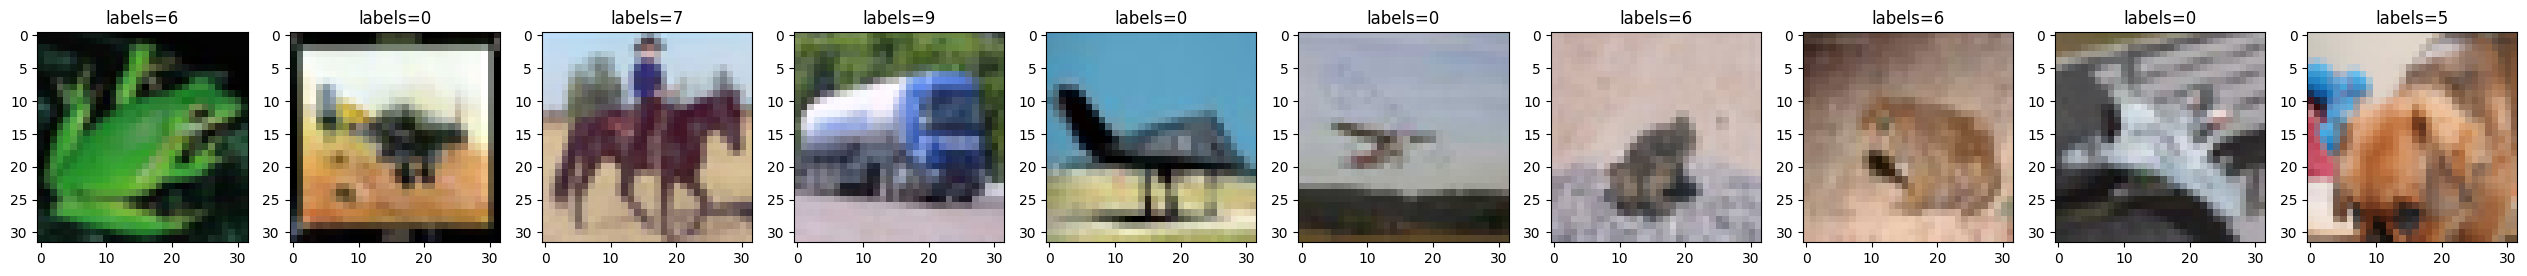

In [17]:
import itertools
import matplotlib.pyplot as plt

user, seed = next(federated_dataset)
print('User: {}\nunique user seed: {}\ndataset length: {}\nfirst 10 images:'.format(user.user_id, seed, len(user)))
fig, axes = plt.subplots(1,min(len(user),10),figsize=(32,32))
for ax, image, label in itertools.islice(zip(axes, *user.raw_data),10):
    ax.set_title('labels={}'.format(label))
    # Rescale color channels from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    # Convert from (C, H, W) to (H, W, C) for Matplotlib
    image = image.permute(1, 2, 0)
    ax.imshow(((image.cpu().numpy()*255).astype(np.uint8)))

# Creating a model for CIFAR10 dataset

## Defining the model architecture

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional
from pfl.metrics import Weighted


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


pytorch_model = Net()

loss_fn = torch.nn.CrossEntropyLoss()

def loss(inputs: torch.Tensor, targets: torch.Tensor, eval: bool = False) -> torch.Tensor:
    pytorch_model.eval() if eval else pytorch_model.train()
    return loss_fn(pytorch_model(inputs), targets)


@torch.no_grad()
def metrics(inputs: torch.Tensor,
             targets: torch.Tensor,
             eval: bool = True) -> Dict[str, Weighted]:
    pytorch_model.eval() if eval else pytorch_model.train()
    prediction = pytorch_model(inputs)
    logits = torch.argmax(prediction, dim=1)
    num_samples = len(inputs)
    num_predictions = targets.numel()
    correct = torch.sum(torch.eq((logits > 0.0).float(), targets))

    loss = loss_fn(prediction, targets).item()
    return {
        "loss": Weighted(loss, num_samples),
        "accuracy": Weighted(correct, num_predictions)
    }

pytorch_model.loss = loss
pytorch_model.metrics = metrics

## Train with normal Machine Learning

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pytorch_model.parameters(), lr=0.001, momentum=0.9)

In [20]:
from torch.utils.data import DataLoader

for epoch in range(2):  # loop over the dataset multiple times

    print(f'Epoch {epoch}')

    running_loss = 0.0
    for i, data in enumerate(DataLoader(train_set.dataset), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 0
[1,  2000] loss: 2.273
[1,  4000] loss: 2.074
[1,  6000] loss: 1.949
[1,  8000] loss: 1.849
[1, 10000] loss: 1.801
[1, 12000] loss: 1.752
[1, 14000] loss: 1.718
[1, 16000] loss: 1.726
[1, 18000] loss: 1.676
[1, 20000] loss: 1.660
[1, 22000] loss: 1.627
[1, 24000] loss: 1.610
[1, 26000] loss: 1.577
[1, 28000] loss: 1.590
[1, 30000] loss: 1.549
[1, 32000] loss: 1.582
[1, 34000] loss: 1.640
[1, 36000] loss: 1.564
[1, 38000] loss: 1.584
[1, 40000] loss: 1.544
[1, 42000] loss: 1.574
[1, 44000] loss: 1.593
[1, 46000] loss: 1.551
[1, 48000] loss: 1.539
[1, 50000] loss: 1.553
Epoch 1
[2,  2000] loss: 1.512
[2,  4000] loss: 1.530
[2,  6000] loss: 1.534
[2,  8000] loss: 1.533
[2, 10000] loss: 1.492
[2, 12000] loss: 1.513
[2, 14000] loss: 1.537
[2, 16000] loss: 1.553
[2, 18000] loss: 1.458
[2, 20000] loss: 1.513
[2, 22000] loss: 1.490
[2, 24000] loss: 1.469
[2, 26000] loss: 1.441
[2, 28000] loss: 1.467
[2, 30000] loss: 1.510
[2, 32000] loss: 1.456
[2, 34000] loss: 1.596
[2, 36000] loss: 1

## Train with Federated Learning

In [21]:
# Both Jupyter and `pfl` use async. `nest_asyncio` allows `pfl` to run inside the notebook 
import nest_asyncio
nest_asyncio.apply()


# Always import the `pfl` model first before initializing any `pfl` components to let `pfl` know which Deep Learning framework you will use.
import multiprocessing
# Set multiprocessing start method to "spawn" instead of forkserver (which is the default)
# That is because forkserver does not work on Windows, but spawn does.
def init_multiprocessing():
    try:
        multiprocessing.set_start_method("spawn", force=True)  # Forces "spawn"
    except RuntimeError:
        pass  # Ignore if it's already set

init_multiprocessing()

from pfl.model.pytorch import PyTorchModel

In [22]:
params = [p for p in pytorch_model.parameters() if p.requires_grad]

model = PyTorchModel(pytorch_model, 
                     local_optimizer_create=torch.optim.SGD,
                     central_optimizer=torch.optim.SGD(params, 1.0))


In [23]:
from pfl.aggregate.simulate import SimulatedBackend

cohort_size = 10
central_num_iterations = 5

# Instantiate simulated federated averaging
simulated_backend = SimulatedBackend(
    training_data=federated_dataset,
    val_data=None)

In [24]:
from pfl.algorithm import FederatedAveraging, NNAlgorithmParams
from pfl.callback import CentralEvaluationCallback
from pfl.hyperparam import NNTrainHyperParams, NNEvalHyperParams

model_train_params = NNTrainHyperParams(
    local_learning_rate=0.01,
    local_num_epochs=2,
    local_batch_size=16)

model_eval_params = NNEvalHyperParams(local_batch_size=20)

algorithm_params = NNAlgorithmParams(
    central_num_iterations=central_num_iterations,
    evaluation_frequency=4,
    train_cohort_size=cohort_size,
    val_cohort_size=0)

callbacks = [
    CentralEvaluationCallback(
        Dataset(raw_data=[all_features, all_labels]),
        model_eval_params=model_eval_params,
        frequency=4),
]

model = FederatedAveraging().run(
    algorithm_params=algorithm_params,
    backend=simulated_backend,
    model=model,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks)


Metrics at iteration 0 ():
    Central val | loss                                : 0.06936974769473075
    Central val | accuracy                            : 0.13646
    Central val | number of data points               : 50000
    Train population | number of devices              : 10
    Train population | number of data points          : 10.0
    Train population | loss before local training     : 0.16187467098236083
    Train population | accuracy before local training : 0.16
    Train population | loss after local training      : 0.1344655442237854
    Train population | accuracy after local training  : 0.16
    Train population | total weight                   : 1.0
    Number of parameters                              : 62006
    Learning rate                                     : 1.0
Metrics at iteration 1 ():
    Train population | number of devices              : 10
    Train population | number of data points          : 10.0
    Train population | total weight              